### Setup

```bash
ssh -L 8000:localhost:8000 rpi.local
johno@rpi:~ $ cd pipette
johno@rpi:~/pipette $ source .venv/bin/activate
(.venv) johno@rpi:~/pipette $ pip install fastapi uvicorn pyserial dynamixel-sdk
python3 api_server.py
```

I have a server running on rpi.local controlling a 3D printer with an attached pipette, the pipette is servo-controlled. What’s included

  - POST /printer/send_gcode: sends G-code, then optionally issues M400 to wait for all moves to finish, and returns the response lines.
  - GET /printer/ports: lists available serial ports to help find the Ender-3 V3 SE port.
  - POST /servo/disable_torque: disables torque and returns the readback state.
  - GET /servo/read_position: reads present position (ticks + degrees).
  - POST /servo/move: enables torque, writes goal position, optionally waits until within tolerance.

## Basic Controls

In [ ]:
import time
from httpx import get, post

In [ ]:
BASE = "http://localhost:8000"

In [ ]:
# List available serial ports (find your printer)
get(f"{BASE}/printer/ports").json()

{'ports': [{'device': '/dev/ttyUSB0',
   'description': 'USB Serial',
   'hwid': 'USB VID:PID=1A86:7523 LOCATION=3-1.3'},
  {'device': '/dev/ttyACM0',
   'description': 'USB Single Serial',
   'hwid': 'USB VID:PID=1A86:55D3 SER=575E003306 LOCATION=3-1.2:1.0'},
  {'device': '/dev/ttyAMA10', 'description': 'n/a', 'hwid': 'n/a'}]}

In [ ]:
# Get current position
post(f"{BASE}/printer/send_gcode", json={"gcode": "M114", "wait": True}).json()

{'port': '/dev/ttyUSB0',
 'baud': 115200,
 'responses': ['X:-11.00 Y:-18.00 Z:0.00 E:0.00 Count X:-880 Y:-1440 Z:0',
  'ok',
  'ok'],
 'move_completed': True}

In [ ]:
# Set current position as 100, 100, 0
post(f"{BASE}/printer/send_gcode", json={"gcode": "G92 X100 Y100 Z0"}).json()

{'port': '/dev/ttyUSB0',
 'baud': 115200,
 'responses': ['X:100.00 Y:100.00 Z:0.00 E:0.00 Count X:-8880 Y:-5440 Z:4000',
  'ok',
  'ok'],
 'move_completed': True}

In [ ]:
# Move to position (X, Y, Z in mm)
post(f"{BASE}/printer/send_gcode", json={"gcode": "G1 X80 Y50 Z10", "wait": True}).json()

{'port': '/dev/ttyUSB0',
 'baud': 115200,
 'responses': ['ok', 'echo:busy: processing', 'ok'],
 'move_completed': True}

In [ ]:
# Enable steppers
post(f"{BASE}/printer/send_gcode", json={"gcode": "M17"}).json()

{'port': '/dev/ttyUSB0',
 'baud': 115200,
 'responses': ['ok', 'ok'],
 'move_completed': True}

In [ ]:
# Disable steppers (allows manual positioning)
post(f"{BASE}/printer/send_gcode", json={"gcode": "M84"}).json()

{'port': '/dev/ttyUSB0',
 'baud': 115200,
 'responses': ['ok', 'ok'],
 'move_completed': True}

In [ ]:
# Set acceleration (mm/s²) - P=print, T=travel
post(f"{BASE}/printer/send_gcode", json={"gcode": "M204 P500 T500", "wait": True}).json()

{'port': '/dev/ttyUSB0',
 'baud': 115200,
 'responses': ['ok', 'ok'],
 'move_completed': True}

In [ ]:
# Read servo position (ticks and degrees)
get(f"{BASE}/servo/read_position").json()

{'dxl_id': 1, 'present_position': 1206, 'present_degrees': 105.99609375}

In [ ]:
# Move servo to position (wait=True blocks until reached)
post(f"{BASE}/servo/move", json={"goal_position": 1200, "wait": True}).json()

{'dxl_id': 1, 'present_position': 1206, 'present_degrees': 105.99609375}

In [ ]:
# Disable servo torque (allows manual adjustment)
post(f"{BASE}/servo/disable_torque", json={}).json()

## Drawing a Picture

Color reservoirs at: red (142, 45), green (167, 45), blue (192, 45). Petri dish centered at (100, 100).

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

COLOR_POSITIONS = {'r': (142, 45), 'g': (167, 45), 'b': (192, 45)}

def drop_color(x, y, color, z=0, zh=10, zw=4, servo_base=1100, sa=40, sp=50, timeout=30, purge=False):
    """Pick up colored liquid and dispense at (x, y). color is 'r', 'g', or 'b'."""
    cx, cy = COLOR_POSITIONS[color]
    
    # Reset pipette to empty position
    post(f"{BASE}/servo/move", json={"goal_position": servo_base, "wait": False})
    time.sleep(0.3)
    
    # Move to color reservoir
    post(f"{BASE}/printer/send_gcode", json={"gcode": f"G1 Z{zh}", "wait": True}, timeout=timeout)
    post(f"{BASE}/printer/send_gcode", json={"gcode": f"G1 X{cx} Y{cy}", "wait": True}, timeout=timeout)
    
    # Push air out before dipping
    post(f"{BASE}/servo/move", json={"goal_position": servo_base - sa, "wait": False})
    time.sleep(0.3)
    
    # Dip into reservoir and draw up liquid
    post(f"{BASE}/printer/send_gcode", json={"gcode": f"G1 Z{zw}", "wait": True}, timeout=timeout)
    post(f"{BASE}/servo/move", json={"goal_position": servo_base, "wait": False})
    time.sleep(0.3)
    
    # Move to target position
    post(f"{BASE}/printer/send_gcode", json={"gcode": f"G1 Z{zh}", "wait": True}, timeout=timeout)
    post(f"{BASE}/printer/send_gcode", json={"gcode": f"G1 X{x} Y{y}", "wait": True}, timeout=timeout)
    post(f"{BASE}/printer/send_gcode", json={"gcode": f"G1 Z{z}", "wait": True}, timeout=timeout)
    
    # Dispense drop
    post(f"{BASE}/servo/move", json={"goal_position": servo_base - sa, "wait": False})
    time.sleep(0.3)
    
    # Lift then purge (avoids bubbles)
    if purge:
        post(f"{BASE}/printer/send_gcode", json={"gcode": f"G1 Z{z+2}", "wait": True}, timeout=timeout)
        post(f"{BASE}/servo/move", json={"goal_position": servo_base - sa - sp, "wait": False})
        time.sleep(0.3)

    # Lift up
    post(f"{BASE}/printer/send_gcode", json={"gcode": f"G1 Z{zh}", "wait": True}, timeout=timeout)
    
    # Reset pipette
    post(f"{BASE}/servo/move", json={"goal_position": servo_base, "wait": False})


def pixels_to_coords(pixels, cx=100, cy=100, pixel_size=8):
    """Convert 8x8 pixel grid to printer coordinates centered at (cx, cy)."""
    coords = []
    for row, col, color in pixels:
        x = cx + (col - 3.5) * pixel_size
        y = cy + (3.5 - row) * pixel_size
        coords.append((x, y, color))
    return coords


def viz_in_dish(pixels, dish_diameter=90, cx=100, cy=100, pixel_size=8):
    """Preview pixel art in petri dish. pixels: list of (row, col, color)."""
    color_map = {'r': 'red', 'g': 'green', 'b': 'blue'}
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Draw petri dish outline
    dish = patches.Circle((cx, cy), dish_diameter/2, fill=False, edgecolor='gray', lw=2)
    ax.add_patch(dish)
    
    # Draw pixels at printer coordinates
    for x, y, color in pixels_to_coords(pixels, cx, cy, pixel_size):
        circle = patches.Circle((x, y), pixel_size/2.5, color=color_map[color], alpha=0.7)
        ax.add_patch(circle)
    
    ax.set_xlim(cx - 50, cx + 50)
    ax.set_ylim(cy - 50, cy + 50)
    ax.set_aspect('equal')
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_title(f'Pixel Art in {dish_diameter}mm Petri Dish')

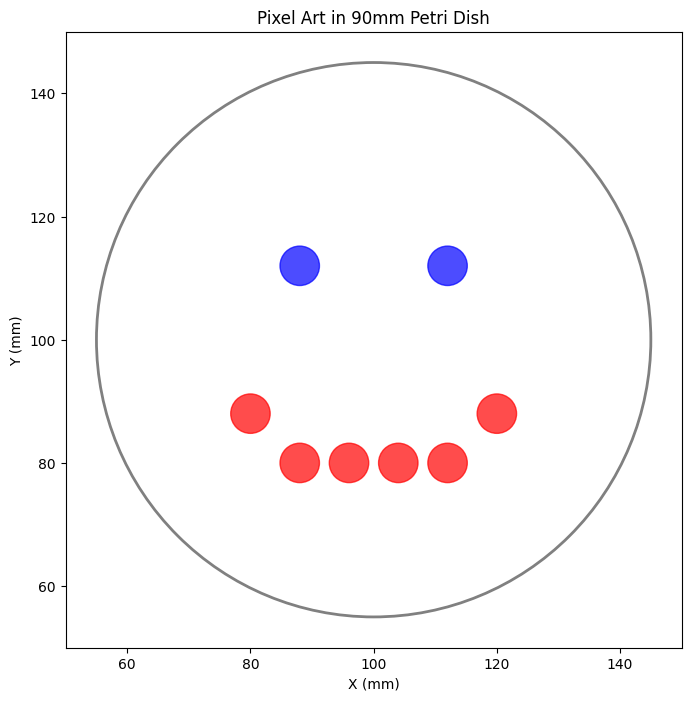

In [ ]:
# Simple smiley face
smiley = [
    (2, 2, 'b'), (2, 5, 'b'), # Eyes
    (5, 1, 'r'), (5, 6, 'r'), # Smile
    (6, 2, 'r'), (6, 3, 'r'), (6, 4, 'r'), (6, 5, 'r'),
]
viz_in_dish(smiley)

In [ ]:
def hover_color(color, zh=10):
    """Move to hover above a color reservoir. color is 'r', 'g', or 'b'."""
    cx, cy = COLOR_POSITIONS[color]
    post(f"{BASE}/printer/send_gcode", json={"gcode": f"G1 Z{zh}", "wait": True})
    post(f"{BASE}/printer/send_gcode", json={"gcode": f"G1 X{cx} Y{cy}", "wait": True})

In [ ]:
hover_color('r')  # hover above red
# hover_color('g')  # hover above green
# hover_color('b')  # hover above blue

In [ ]:
def goto_z(z):
    """Move to a specific Z height."""
    post(f"{BASE}/printer/send_gcode", json={"gcode": f"G1 Z{z}", "wait": True})

In [ ]:
goto_z(15)

In [ ]:
for x, y, color in pixels_to_coords(smiley):
    drop_color(x, y, color, zw=2, z=0, zh=10)

In [ ]:
goto_z(25)

In [ ]:
# Print the picture!
coords = pixels_to_coords(rainbow_heart, pixel_size=8)
for x, y, color in coords:
    drop_color(x, y, color)


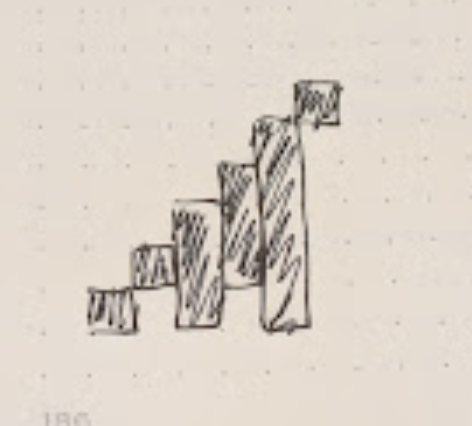

Target

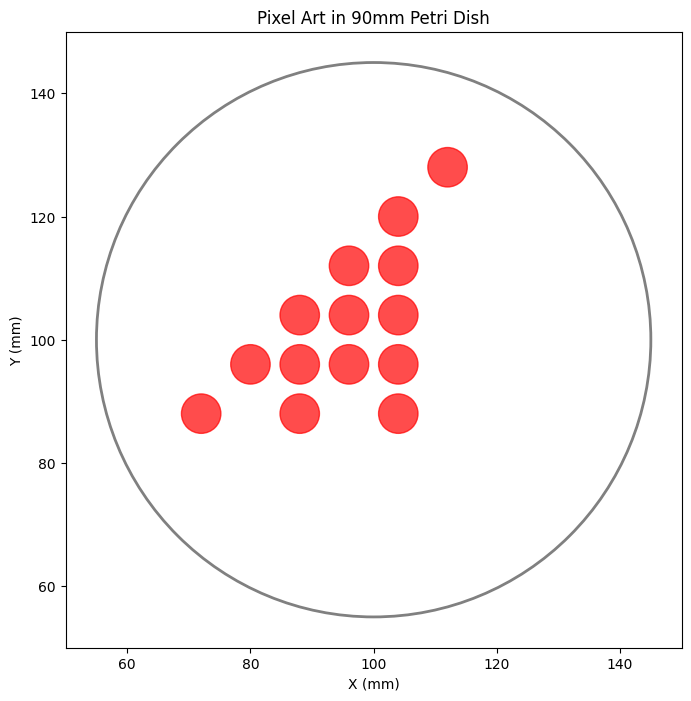

In [ ]:
dino = [
    (0, 5, 'r'), # Head
    (1, 4, 'r'), # Neck
    (2, 3, 'r'), (2, 4, 'r'),
    (3, 2, 'r'), (3, 3, 'r'), (3, 4, 'r'),
    (4, 1, 'r'), (4, 2, 'r'), (4, 3, 'r'), (4, 4, 'r'),
    (5, 0, 'r'), (5, 2, 'r'), (5, 4, 'r')
]
viz_in_dish(dino)

In [ ]:
for x, y, color in pixels_to_coords(dino, pixel_size=8):
    drop_color(x, y, color, zw=5, z=0, zh=15)

In [ ]:
goto_z(15)

In [ ]:
# servo_base, sa, sp = 1100, 40, 50
# post(f"{BASE}/servo/move", json={"goal_position": servo_base - sa - sp, "wait": False})
# time.sleep(0.3)